# NumPy Reader

## Overview

This example shows how to read NumPy array files (*.npy) with DALI's ``readers.Numpy`` reader in dynamic mode. This notebook also shows how to use DALI to load NumPy files directly to GPU memory, thanks to NVIDIA GPUDirect Storage, and how to use the region-of-interest (ROI) API to load regions of the array.

The reader extracts the shape and the data type information directly from the files. Please note that only NumPy v1 (and not v2) files are currently supported. NumPy v1 are the most commonly used. See the [numpy file format specification](https://numpy.org/neps/nep-0001-npy-format.html) for more details.

The operator returns arrays with shapes taken from the files. DALI tensors are always stored in C (row-major) order. If the files contain the data in FORTRAN (column-major) order, the operator will automatically transpose the data to C order. This transposition adds significant time to the loading process. Therefore, we recommend storing files in C order when possible.

## Test data

In this example we are going to work with 3D MRI data, available in the [DALI_extra](https://github.com/NVIDIA/DALI_extra) repository. The environment variable ``DALI_EXTRA_PATH`` should point to the location of DALI_extra. Ensure that you check out the correct release tag that corresponds to the installed version of DALI. 

We will be working with 3D MRI scans in two formats:

1. 2D slices, with one file per slice:

```
npy_2d_slices
└── STU00001
    ├── SER00001
    │   ├── 0.npy
    │   ├── 1.npy
    │   ├── 2.npy
    │   ├── 3.npy
    │   └── 4.npy
```

2. 3D arrays with the whole volume

```
npy_3d
└── STU00001
    ├── SER00001.npy
```

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import nvidia.dali.experimental.dynamic as ndd

batch_size = 4
dali_extra_dir = Path(os.environ["DALI_EXTRA_PATH"])
data_dir_2d = (
    dali_extra_dir / "db" / "3D" / "MRI" / "Knee" / "npy_2d_slices" / "STU00001"
)
data_dir_3d = (
    dali_extra_dir / "db" / "3D" / "MRI" / "Knee" / "npy_3d" / "STU00001"
)

Let us introduce a utility function to plot tensors:

In [2]:
def plot_tensors(*tensors: np.ndarray | ndd.Tensor):
    nsamples = len(tensors)
    fig, axes = plt.subplots(nrows=1, ncols=nsamples, figsize=(5 * nsamples, 5))
    if nsamples == 1:
        axes = [axes]

    for i, tensor in enumerate(tensors):
        axes[i].tick_params(
            left=False, bottom=False, labelleft=False, labelbottom=False
        )
        axes[i].imshow(Image.fromarray(np.asarray(tensor)))

    plt.tight_layout()
    plt.show()

We can check that the data is equivalent in both representations:

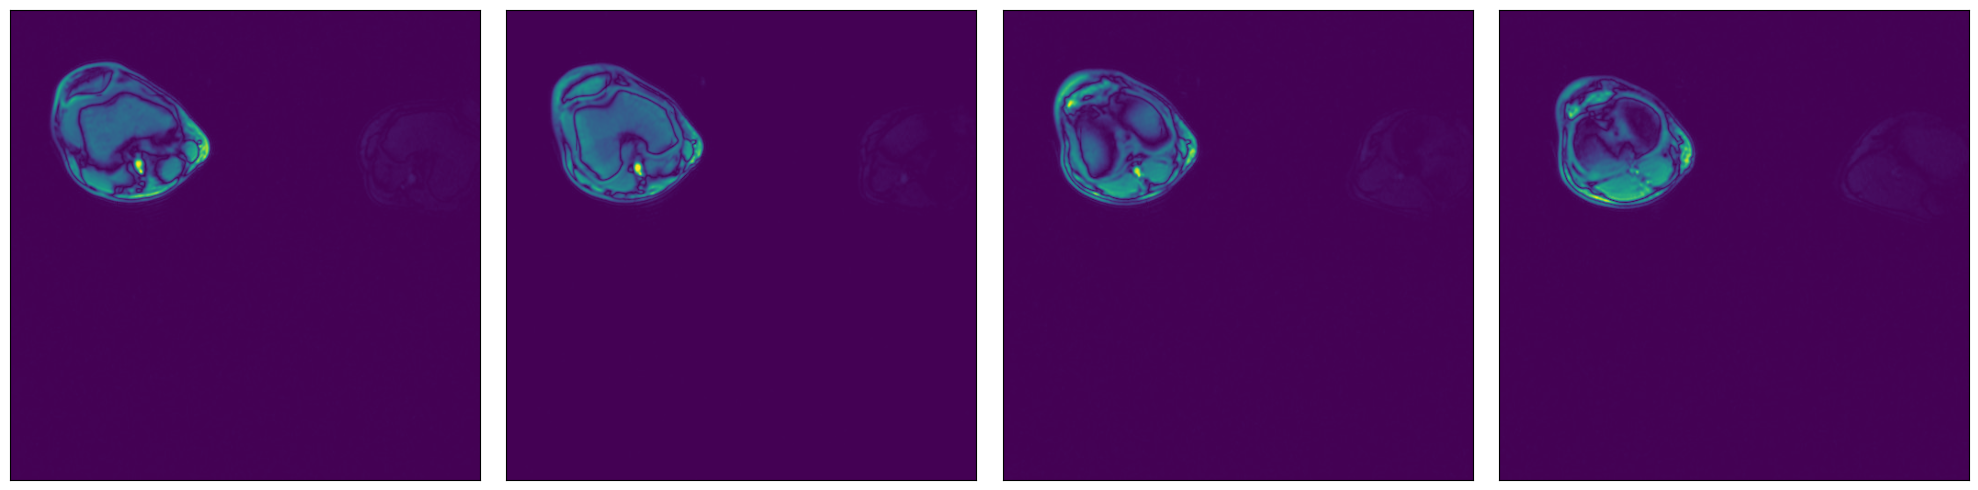

In [3]:
ser00001_2d = [np.load(data_dir_2d / "SER00001" / f"{i}.npy") for i in range(4)]
plot_tensors(ser00001_2d[0], ser00001_2d[1], ser00001_2d[2], ser00001_2d[3])

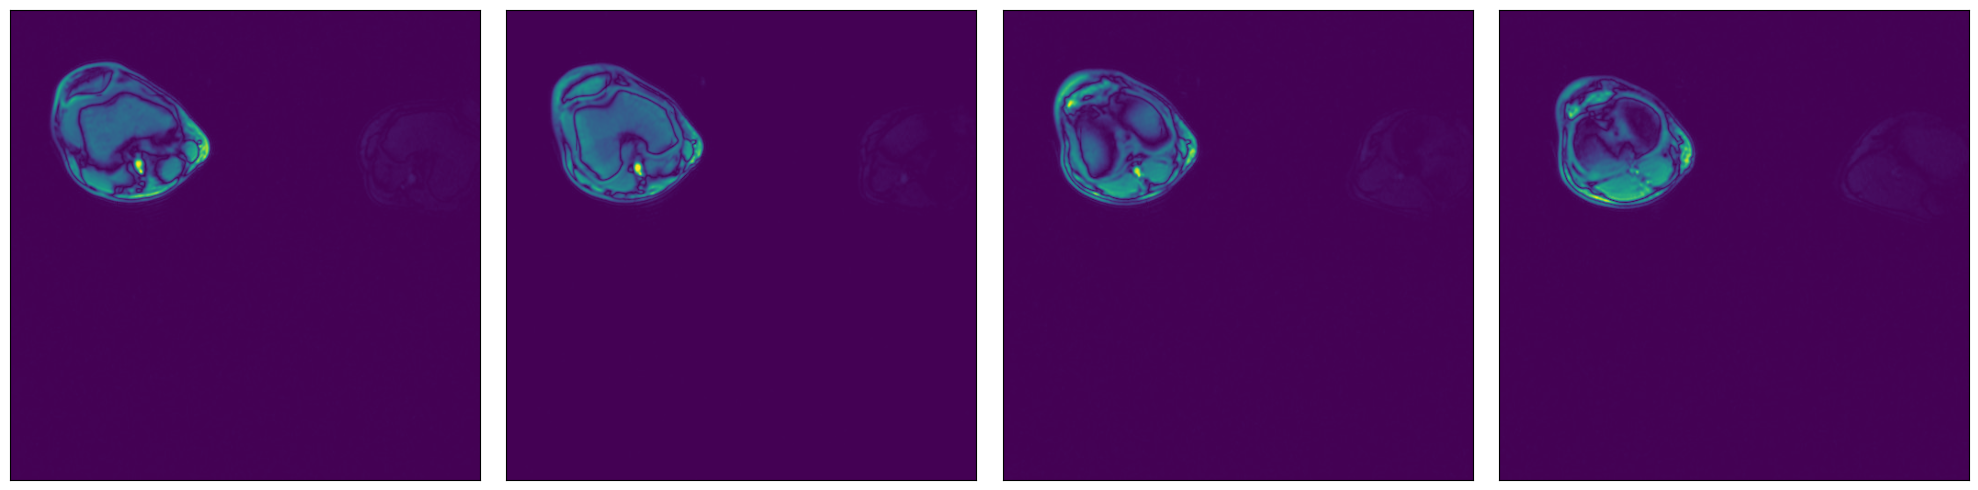

In [4]:
ser00001_3d = np.load(data_dir_3d / "SER00001.npy")
plot_tensors(ser00001_3d[0], ser00001_3d[1], ser00001_3d[2], ser00001_3d[3])

## Usage

The ``readers.Numpy`` reader can be configured in different ways. Let us see some examples.

### Glob filter

Read all files under a specified directory specified by the argument ``file_root``, that match a particular glob string, specified by the ``file_filter`` argument.

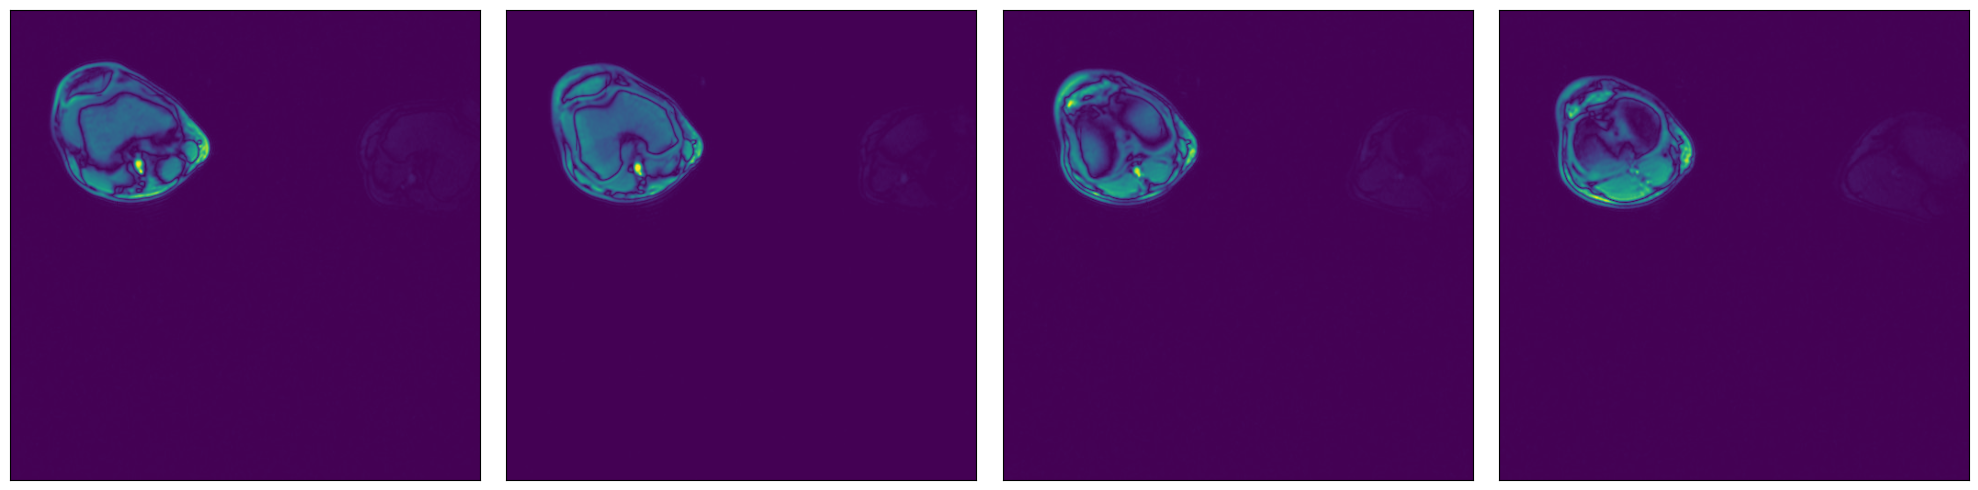

In [5]:
data_dir = data_dir_2d / "SER00001"

reader = ndd.readers.Numpy(file_root=data_dir, file_filter="*.npy")

for (batch1,) in reader.next_epoch(batch_size=batch_size):
    plot_tensors(*batch1)
    break  # Run once

### Text file with a list of file paths

Read all files specified by a text file where each line contains a path to a file, relative to the ``file_root`` directory.

In [6]:
import tempfile


def assert_all_equal(batch1: ndd.Batch, batch2: ndd.Batch):
    for t1, t2 in zip(batch1, batch2):
        np.testing.assert_array_equal(t1, t2)


files = sorted(f.name for f in data_dir.glob("*.npy"))

with tempfile.TemporaryDirectory() as tmp_dir:
    filelist_path = Path(tmp_dir) / "test_file_list.txt"
    filelist_path.write_text("\n".join(files))

    print("File list contents:")
    print(filelist_path.read_text())
    print("\n")

    reader = ndd.readers.Numpy(file_root=data_dir, file_list=filelist_path)

    for (batch2,) in reader.next_epoch(batch_size=batch_size):
        break

    assert_all_equal(batch1, batch2)

File list contents:
0.npy
1.npy
2.npy
3.npy
4.npy




### List of file paths

Read all files specified by a list of strings containing file paths, relative to the ``file_root`` directory.

In [7]:
reader = ndd.readers.Numpy(file_root=data_dir, files=files)

for (batch3,) in reader.next_epoch(batch_size=batch_size):
    break

assert_all_equal(batch1, batch3)

### Higher dimensionality

NumPy reader can also be used to load data of higher dimensionality (up to 6 dimensions). Let's demonstrate with our 3D MRI arrays.

Sample shape: (5, 512, 512)


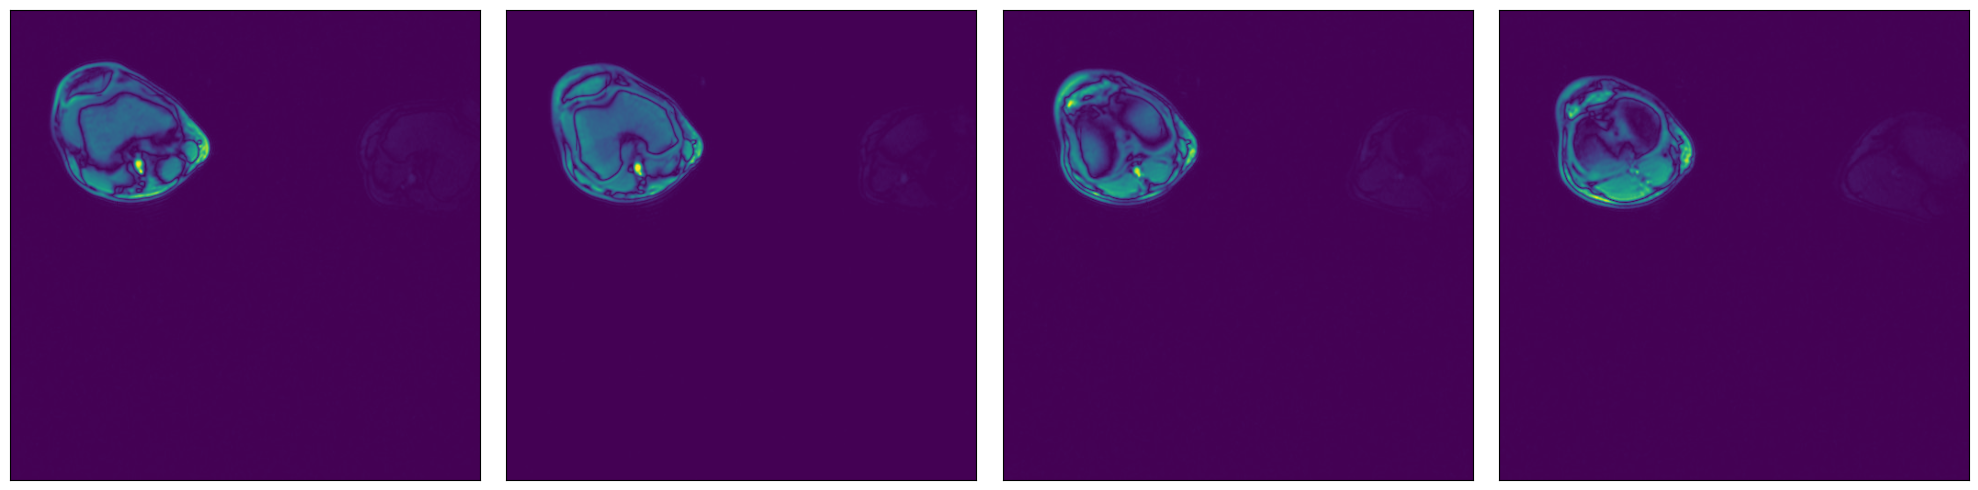

In [8]:
reader = ndd.readers.Numpy(file_root=data_dir_3d, file_filter="*.npy")
tensor_3d = reader()

print(f"Sample shape: {tensor_3d.shape}")
plot_tensors(
    tensor_3d[0, :, :],
    tensor_3d[1, :, :],
    tensor_3d[2, :, :],
    tensor_3d[3, :, :],
)

## Region-of-interest (ROI) API

In the example shown above, we see that the relevant data is concentrated in the upper left quadrant of the image and the rest does not contain useful information. This is not true for all the images in the dataset, but it will serve us as a good example to demonstrate ROI reading.

NumPy reader allows the user to specify a region of interest, equivalent to the arguments specified to ``slice`` operation. The benefit is that the reader will only read the relevant part of the file, saving I/O bandwidth and memory utilization. Note that setting the ``dont_use_mmap`` argument to False will negate that performance benefit, with the entire file being read first and then sliced.

The ROI can be specified in absolute or relative terms, and can be specified on a subset of the array's axes. For dimensions not specified in the ROI, the whole extent of the array shall be used. For full documentation on ROI decoding, refer to [readers.numpy documentation](../../../operations/nvidia.dali.fn.readers.numpy.html) (see arguments ``roi_start``, ``rel_roi_start``, ``roi_end``, ``rel_roi_end``, ``roi_shape``, ``rel_roi_shape``, ``axes``).

<div class="alert alert-info">
<b>Note</b><br>

To specify the ROI, it is necessary to call the reader directly instead of using the `next_epoch` iterator: `reader(roi_start=..., roi_end=...)`
</div>

Let us see a few practical examples:

### ROI start and end, in absolute coordinates

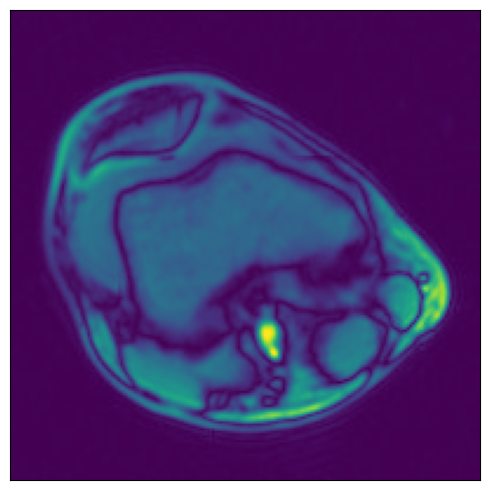

In [9]:
# One file is enough for this example
files = ["0.npy"]

reader = ndd.readers.Numpy(file_root=data_dir, files=files)
plot_tensors(reader(roi_start=[30, 30], roi_end=[230, 230]))

### ROI start and end, in relative coordinates

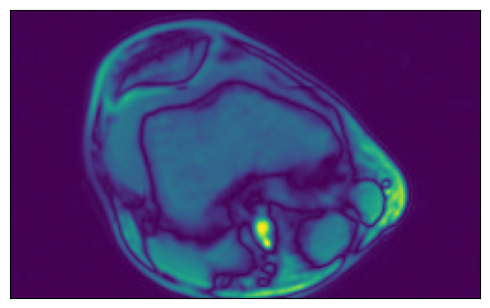

In [10]:
reader = ndd.readers.Numpy(file_root=data_dir, files=files)
plot_tensors(reader(rel_roi_start=[0.1, 0.01], rel_roi_end=[0.4, 0.5]))

### Specifying a subset of the array's axes

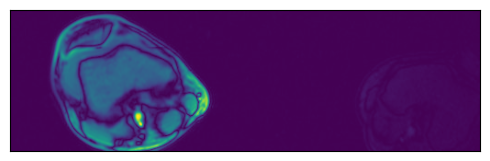

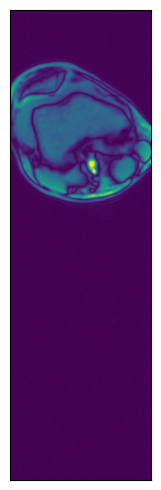

In [11]:
reader1 = ndd.readers.Numpy(file_root=data_dir, files=files, roi_axes=(0,))
plot_tensors(reader1(rel_roi_start=[0.1], rel_roi_end=[0.4]))

reader2 = ndd.readers.Numpy(file_root=data_dir, files=files, roi_axes=(1,))
plot_tensors(reader2(rel_roi_start=[0.1], rel_roi_end=[0.4]))

### Out of bounds access

Additionally, the user can choose what happens when a ROI falls outside of the bounds of the array. By default, out-of-bounds access results in an error, but it can be controlled by the ``out_of_bounds_policy`` argument.

Let us see an example of a reader configured to pad with zeros when the ROI falls out of bounds:

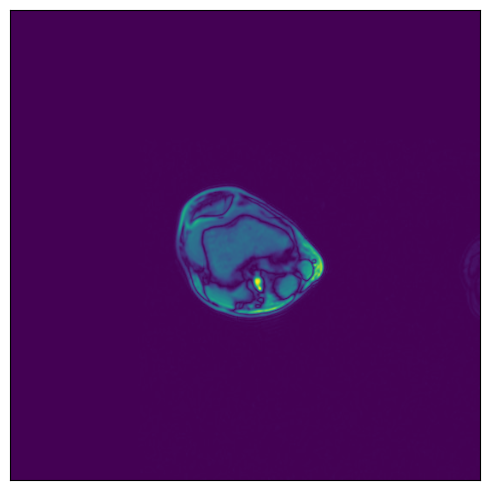

In [12]:
reader = ndd.readers.Numpy(
    file_root=data_dir,
    files=files,
    out_of_bounds_policy="pad",
    fill_value=0,
)
plot_tensors(reader(roi_start=(-150, -150), roi_end=(400, 400)))

## GPUDirect Storage Support

DALI NumPy Reader supports [GPUDirect Storage (GDS)](https://developer.nvidia.com/gpudirect-storage) via libcufile. GDS enables a direct data path between storage and GPU memory and avoids extra copies through a bounce buffer in the CPU's memory.

In order to enable GDS support in DALI, make sure GDS is installed. On Systems with CUDA 11.4 or newer, GDS is already installed as part of the CUDA 11.4 SDK. For older CUDA releases, please install GDS separately (follow the link above for instructions).

Once GDS is installed, it can be used by simply switching the device of the reader to ``"gpu"``.

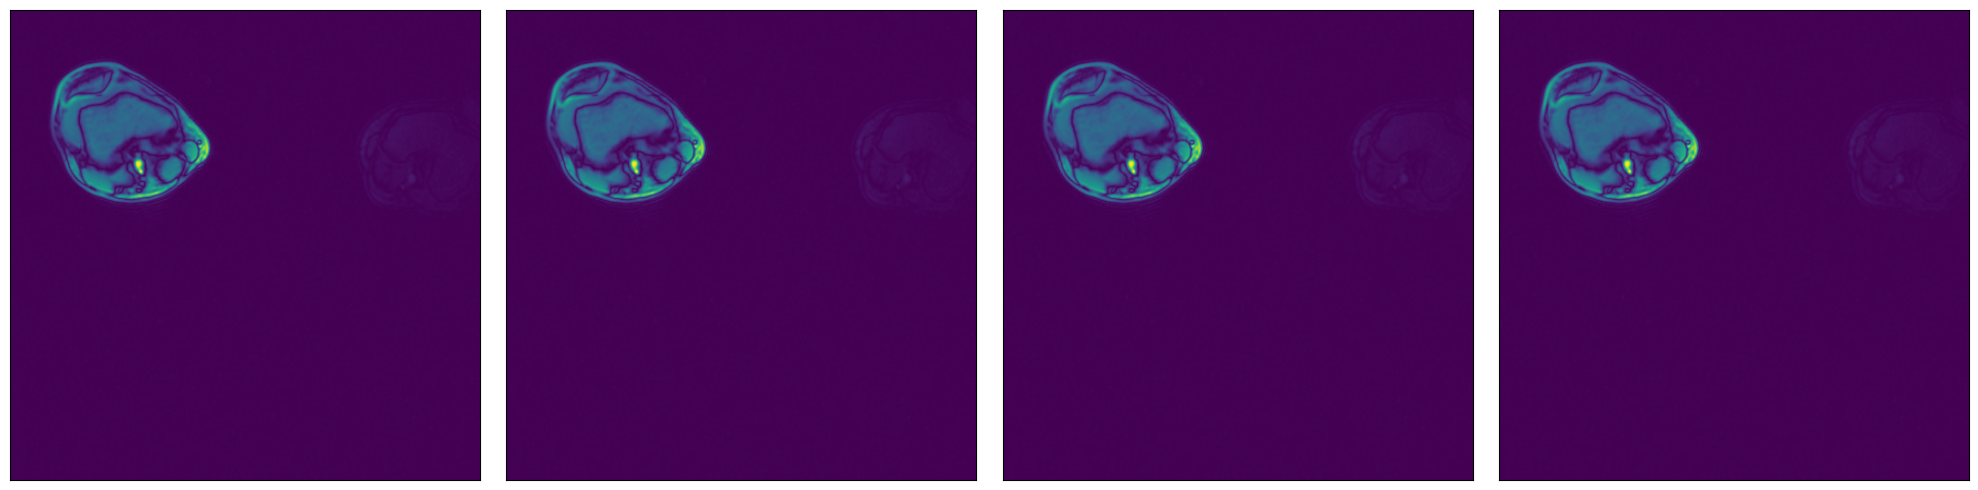

In [13]:
reader = ndd.readers.Numpy(device="gpu", file_root=data_dir, files=files)

for (batch,) in reader.next_epoch(batch_size=batch_size):
    plot_tensors(*batch.cpu())
    break